# Repulsive deep ensembles are Bayesian 

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
import math
import numpy as np
import torch
import torch.autograd as autograd
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
import os 
os.chdir('/Users/fdangelo/Workspace/repulsive_ens/')
from utils.SSGE_squeeze import SpectralSteinEstimator

In [6]:
%config InlineBackend.figure_format = 'retina'
sns.set(style="darkgrid")
matplotlib.rcParams['figure.dpi']= 200
sns.set(style="white")

## RBF Kernel

The RBF kernel is defined as the squared exponential distance between the two vectors. The bandwidth of the kernel is reffered to as  $h$.

$$
k_{RBF}(\mathbf{x}, \mathbf{x}^\prime) = \exp \bigg( {-\frac{1}{h}||\mathbf{x}-\mathbf{x}^\prime||^2} \bigg)
$$


In [8]:
class RBF(torch.nn.Module):
    def __init__(self, h=None):
        super(RBF, self).__init__()

        self.h = h
        
    def median(self,tensor):
        tensor = tensor.flatten().sort()[0]
        length = tensor.shape[0]

        if length % 2 == 0:
            szh = length // 2
            kth = [szh - 1, szh]
        else:
            kth = [(length - 1) // 2]
        return tensor[kth].mean()
    


    def forward(self, X, Y):
        XX = X.matmul(X.t())
        XY = X.matmul(Y.t())
        YY = Y.matmul(Y.t())

        dnorm2 = -2 * XY + XX.diag().unsqueeze(1) + YY.diag().unsqueeze(0)
        
        
        # Apply the median heuristic (PyTorch does not give true median)
        if self.h is None:
            h = self.median(dnorm2.detach()) / (2*torch.tensor(math.log(X.size(0))))
        else:
            h = self.h**2

        gamma = 1.0 / (2*h)
        K_XY = (-gamma * dnorm2).exp()

        return K_XY

## Performing Wasserstein Gradient Descent or Stein Variational Gradient Descent  corresponds to simulate the following discretized ODE for each particle $x_i$ in the system.

### Stein Variational Gradient Descent (SVGD)

$$
     x^{t+1}_i = x^{t}_i + \epsilon_t \bigg( \sum_{j=1}^n k(x_i^t,x_j^t) \nabla_{x_i^t} \log p(x_i^t) + \sum_{j=1}^n\nabla_{x_j^t} k(x_j^t,x_i^t) \bigg)
$$
### Wasserstein Gradient Descent (WGD) with KDE 
$$
    x^{t+1}_i = x^{t}_i + \epsilon_t \bigg( \nabla \log p(x^{t}_i) -  \frac{\sum_{j=1}^n\nabla_{x_i^t} k(x_i^t,x_j^t)}{\sum_{j=1}^n k(x_i^t,x_j^t)}  \bigg) \, ,
$$
###  Wasserstein Gradient Descent with SGE 
$$ 
 x^{t+1}_i = x^{t}_i + \epsilon_t \bigg( \nabla \log \pi(x^{t}_i) +\sum_{j=1}^n (K + \eta \mathbb{I})^{-1}_{ij} \sum_{k=1}^n  \nabla_{x^t_k} k(x^t_k,x^t_j) \bigg)
$$ 
###  Wasserstein Gradient Descent with SSGE 

$$ 
x_{t+1}^i = x_{t}^i + \epsilon_t \bigg( \nabla \log \pi(x_{t}^i) +\sum_{j=1}^J  \frac{1}{\lambda_j^2 }   \sum_{m=1}^n  \sum_{k=1}^n u_{jk} \nabla_{x_m} k(x_m^t,x_k^t) \cdot \sum_{l=1}^n u_{jl}k(x_i^t,x^t_l)  \bigg)
$$ 

In [9]:
class SVGD:
    def __init__(self, P, K, optimizer):
        self.P = P
        self.K = K
        self.optim = optimizer

    def phi(self, X):
        X = X.detach().requires_grad_(True)

        log_prob = self.P.log_prob(X)
        score_func = autograd.grad(log_prob.sum(), X)[0]

        K_XX = self.K(X, X.detach())
        grad_K = -autograd.grad(K_XX.sum(), X)[0]

        phi = (K_XX.detach().matmul(score_func) + grad_K) / X.size(0)
        #phi = score_func

        return phi

    def step(self, X):
        self.optim.zero_grad()
        X.grad = -self.phi(X)
        self.optim.step()

In [10]:
class WGD:
    def __init__(self, P, K, optimizer):
        self.P = P
        self.K = K
        self.optim = optimizer

    def phi(self, X):
        X = X.detach().requires_grad_(True)

        log_prob = self.P.log_prob(X)
        score_func = autograd.grad(log_prob.sum(), X)[0]

        K_XX = self.K(X, X.detach())
        grad_K = autograd.grad(K_XX.sum(), X)[0] 

        phi = ((score_func)-grad_K/ (K_XX.sum(1,keepdim = True))) 
        return phi, score_func, grad_K/ (K_XX.sum(1,keepdim = True))

    def step(self, X):
        self.optim.zero_grad()
        up,att,rep = self.phi(X)
        X.grad = -up
        self.optim.step()
        return att, rep 

In [11]:
class ssge_WGD:
    def __init__(self, P, K, optimizer,grad_estim):
        self.P = P
        self.K = K
        self.optim = optimizer
        self.pge = grad_estim


    def phi(self, X):
        X = X.detach().requires_grad_(True)

        log_prob = self.P.log_prob(X)
        score_func = autograd.grad(log_prob.sum(), X)[0]

        #K_XX = self.K(X, X.detach())
        #grad_K = autograd.grad(K_XX.sum(), X)[0] 
        
        grad_density = self.pge.compute_score_gradients(X, X)  # .mean(0)


        phi = (score_func-grad_density) 
        return phi

    def step(self, X):
        self.optim.zero_grad()
        X.grad = -self.phi(X)
        self.optim.step()

In [12]:
class sge_WGD:
    def __init__(self, P, K, optimizer):
        self.P = P
        self.K = K
        self.optim = optimizer


    def phi(self, X):
        X = X.detach().requires_grad_(True)

        log_prob = self.P.log_prob(X)
        score_func = autograd.grad(log_prob.sum(), X)[0]

        #K_XX = self.K(X, X.detach())
        #grad_K = autograd.grad(K_XX.sum(), X)[0] 
        
        eta = 0.01
        K_X = self.K(X, X.detach())
        grad_K = autograd.grad(K_X.sum(), X)[0] 
        K_ = K_X+eta*torch.eye(K_X.shape[0]) 
        grad_density = torch.linalg.solve(K_,grad_K)
        
        phi = (score_func-grad_density) 
        return phi

    def step(self, X):
        self.optim.zero_grad()
        X.grad = -self.phi(X)
        self.optim.step()

In [13]:
class MAP:
    def __init__(self, P, K, optimizer):
        self.P = P
        self.K = K
        self.optim = optimizer

    def phi(self, X):
        X = X.detach().requires_grad_(True)

        log_prob = self.P.log_prob(X)
        score_func = autograd.grad(log_prob.sum(), X)[0]

        phi = score_func
        #phi = score_func

        return phi

    def step(self, X):
        self.optim.zero_grad()
        X.grad = -self.phi(X)
        self.optim.step()

# Experiments

## Unimodal Gaussian

We will first run the different methods to learn a Multivariate Gaussian Distribution. 

In [12]:
def plot_density_particles(samples,particles,name):
    g = sns.JointGrid(samples[:,0],samples[:,1])
    #plt.title(title)
    sns.scatterplot(particles.detach().numpy()[:,0],particles.detach().numpy()[:,1], color ='orange', ax = g.ax_joint, alpha = 1.0,s = 50, zorder = 1, edgecolor='black', label = name)
    plt.legend(fontsize=20)
    sns.kdeplot(samples[:,0],samples[:,1] ,cmap=plt.cm.Blues, shade=True, levels=15, ax=g.ax_joint, zorder = 0)
    #sns.kdeplot(samples[:,0],samples[:,1] ,cmap=plt.cm.Blues, shade=False, levels=20, ax=g.ax_joint, zorder = 0)
    g.ax_joint.legend()

    #sns.kdeplot(samples[:,0],samples[:,1],fill=True, thresh=0, levels=100, cmap="Blues", ax=g.ax_joint, zorder = 0)
    #sns.kdeplot(X_init.detach().numpy()[:,0],X_init.detach().numpy()[:,1],cmap="Blues", shade=True, shade_lowest=False, ax=g.ax_joint)
    #plt.scatter(X_init.detach().numpy()[:,0],X_init.detach().numpy()[:,1], marker='x', color='r', alpha=0.5)
    sns.distplot(samples[:,0], kde=True, hist=False, color="r", ax=g.ax_marg_x)
    sns.distplot(particles.detach().numpy()[:,0], kde=True, hist=False, color="b", ax=g.ax_marg_x)
    sns.distplot(samples[:,1], kde=True, hist=False, color="r", ax=g.ax_marg_y, vertical=True)
    sns.distplot(particles.detach().numpy()[:,1], kde=True, hist=False, color="b", ax=g.ax_marg_y, vertical=True)
    #g.ax_marg_x.text(-7.8, -0.13,'Epoch:', fontsize=15)
    plt.axis('off')
    #plt.show()
    plt.savefig(name+'.pdf', format='pdf',dpi = 200)
    return g 

In [14]:
gauss = torch.distributions.MultivariateNormal(torch.Tensor([-0.68,0.80]).to(device),
        covariance_matrix=5 * torch.Tensor([[0.22,0.16],[0.16,0.67]]).to(device))

n = 100
X_init = (3 * torch.randn(n, *gauss.event_shape)).to(device)
p_0 = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([-1,5],dtype=torch.float),0.5*torch.eye(2))

X_init = p_0.sample(torch.Size([n]))

In [15]:
samples = gauss.sample(torch.Size([4000])).detach().numpy()

In [16]:
K = RBF(0.5)
lr = 1e-1

In [17]:
X_SVGD = X_init.clone()
X_WGD = X_init.clone()
X_MAP = X_init.clone()
X_sge_WGD = X_init.clone()
X_ssge_WGD = X_init.clone()

svgd = SVGD(gauss, K, optim.Adam([X_SVGD], lr=lr))
wgd = WGD(gauss, K, optim.Adam([X_WGD], lr=lr))
pmap = MAP(gauss, K, optim.Adam([X_MAP], lr=lr))

ssge_k = RBF()
#K = real_PP_K(exp = True)
ssge = SpectralSteinEstimator(0.01,None,ssge_k, device = device)
X_ssge_WGD = X_init.clone()
ssege_wgd = ssge_WGD(gauss, K, optim.Adam([X_ssge_WGD], lr=lr),ssge)
sge_wgd = sge_WGD(gauss, K, optim.Adam([X_sge_WGD], lr=lr))

att_l = []
rep_l = []
t_steps = 10000
for i in tqdm(range(t_steps),position=0, leave=True):       
    svgd.step(X_SVGD)
    att,rep = wgd.step(X_WGD)
    att_l.append(np.linalg.norm(att.detach().numpy()))
    rep_l.append(np.linalg.norm(rep.detach().numpy()))
    pmap.step(X_MAP)
    ssege_wgd.step(X_ssge_WGD)
    sge_wgd.step(X_sge_WGD)


  0%|          | 0/10000 [00:00<?, ?it/s]


AttributeError: module 'torch' has no attribute 'linalg'

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


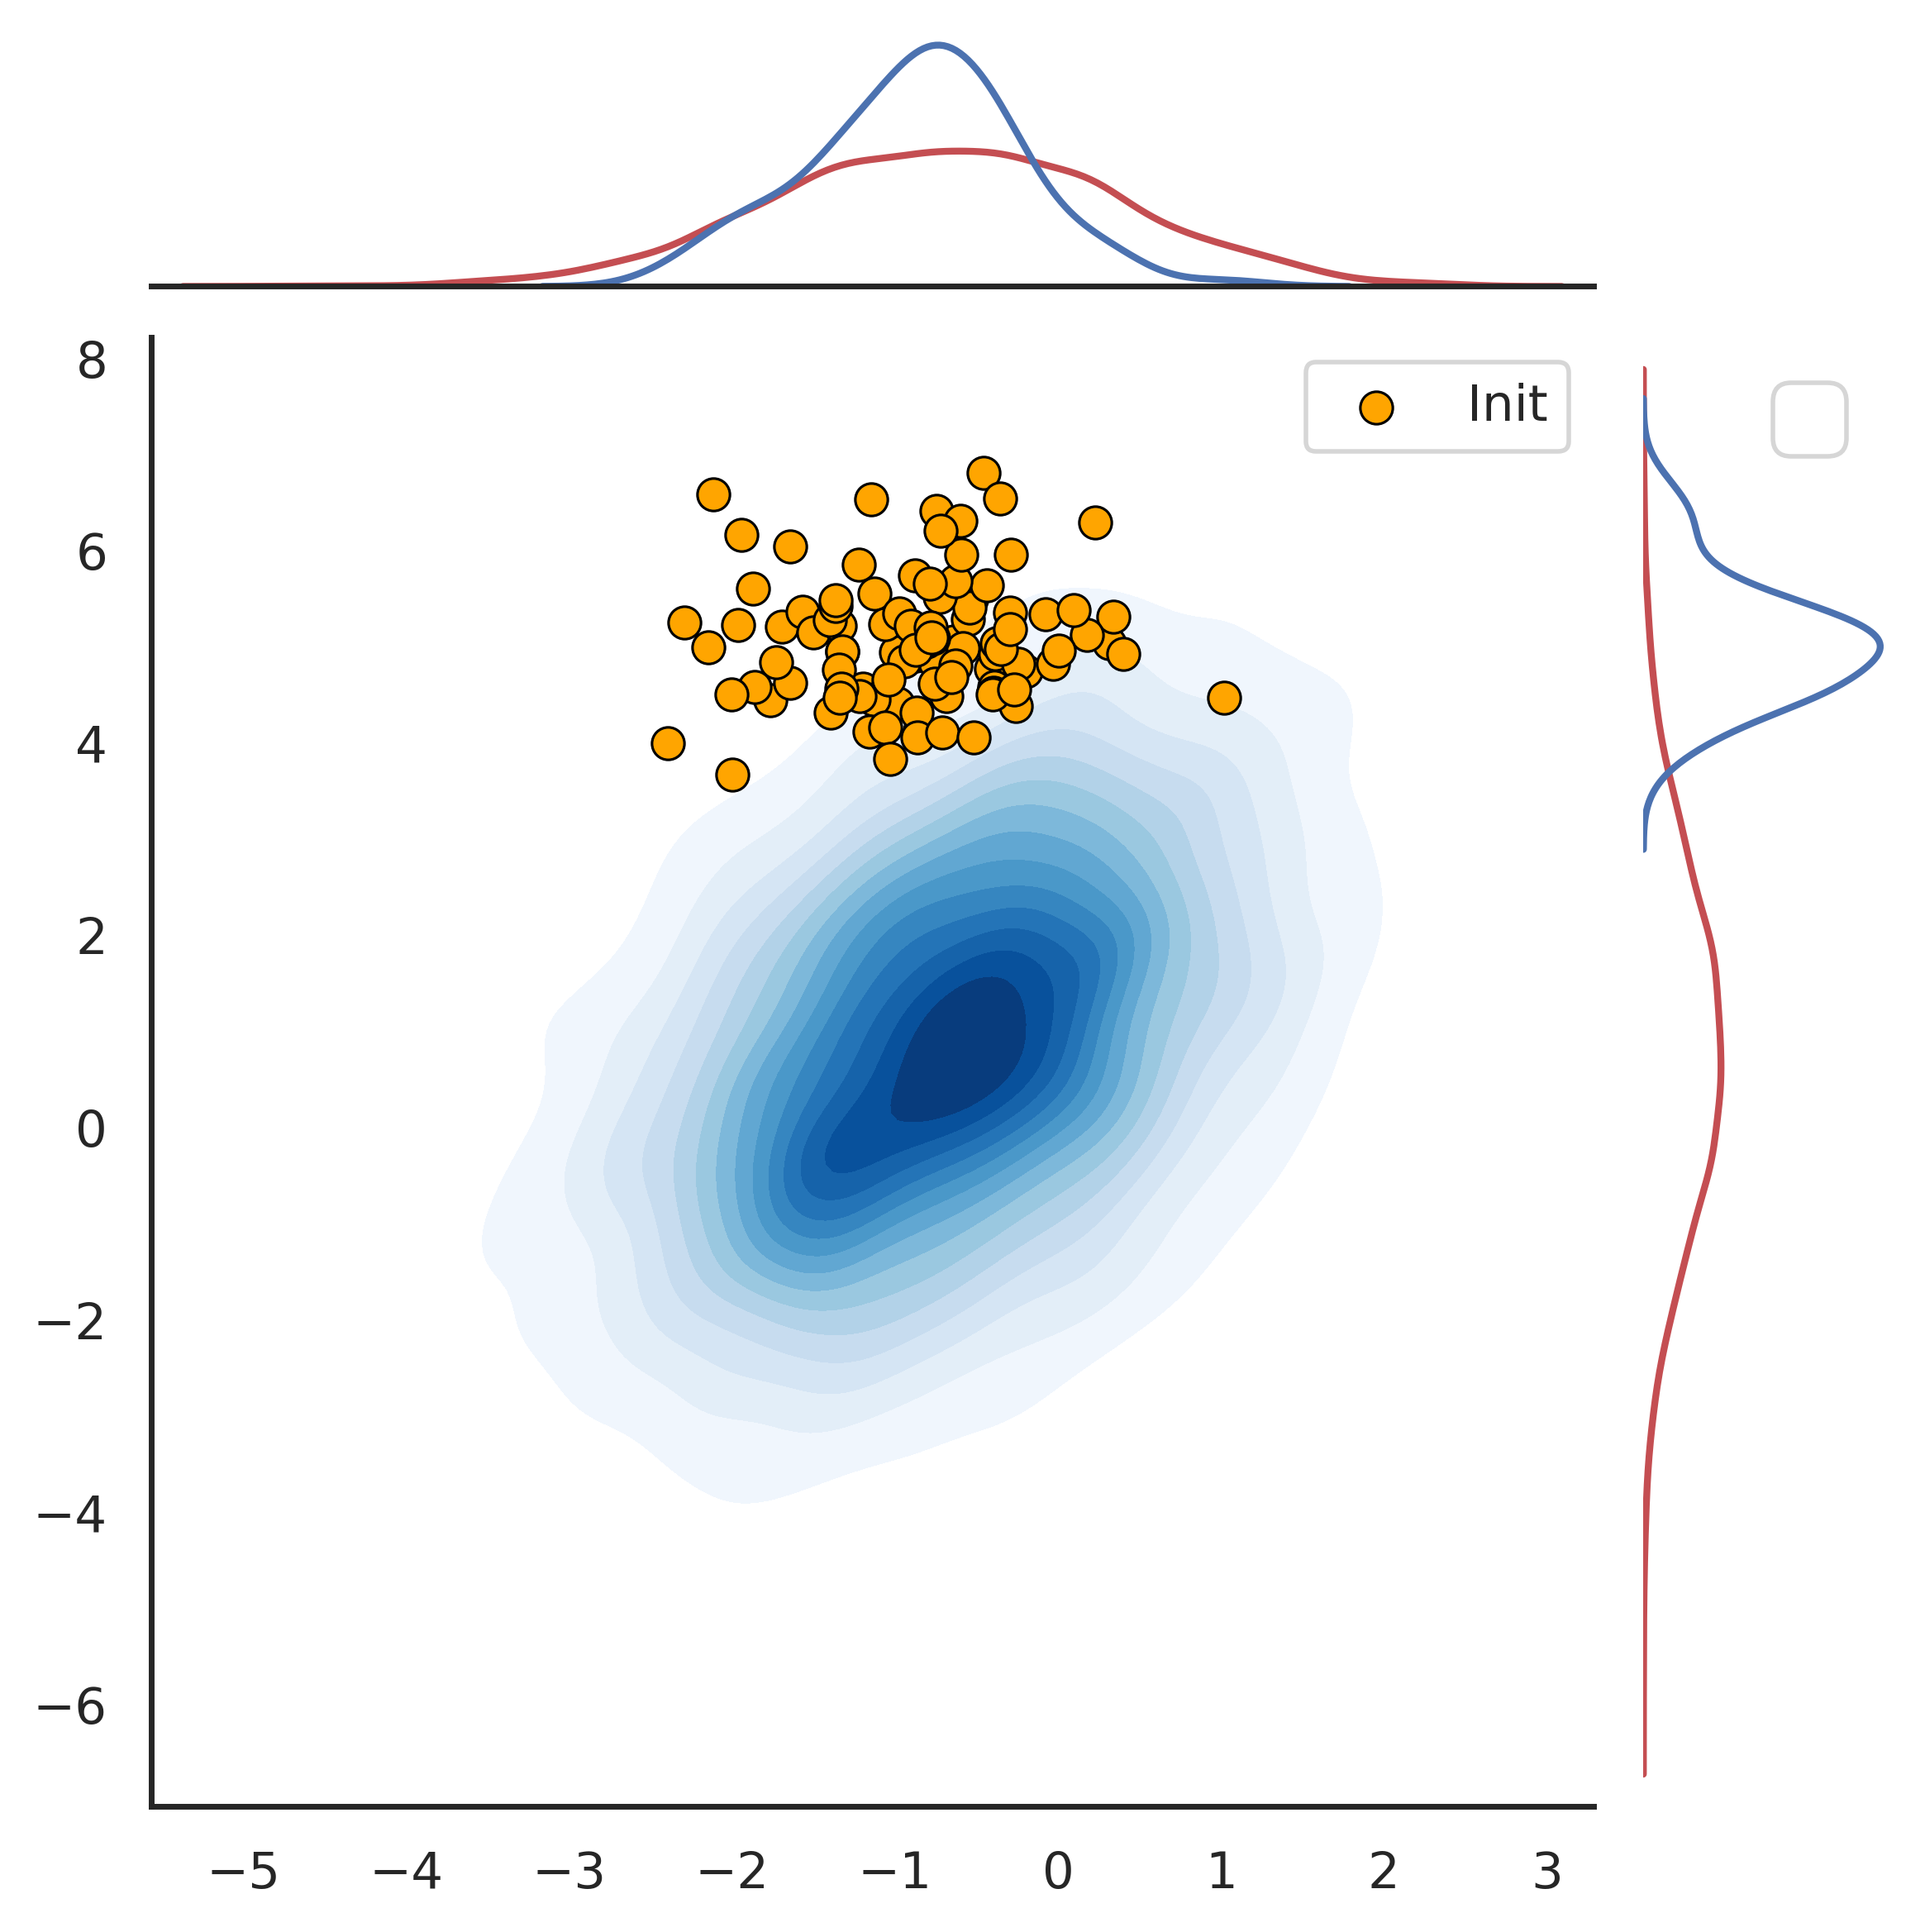

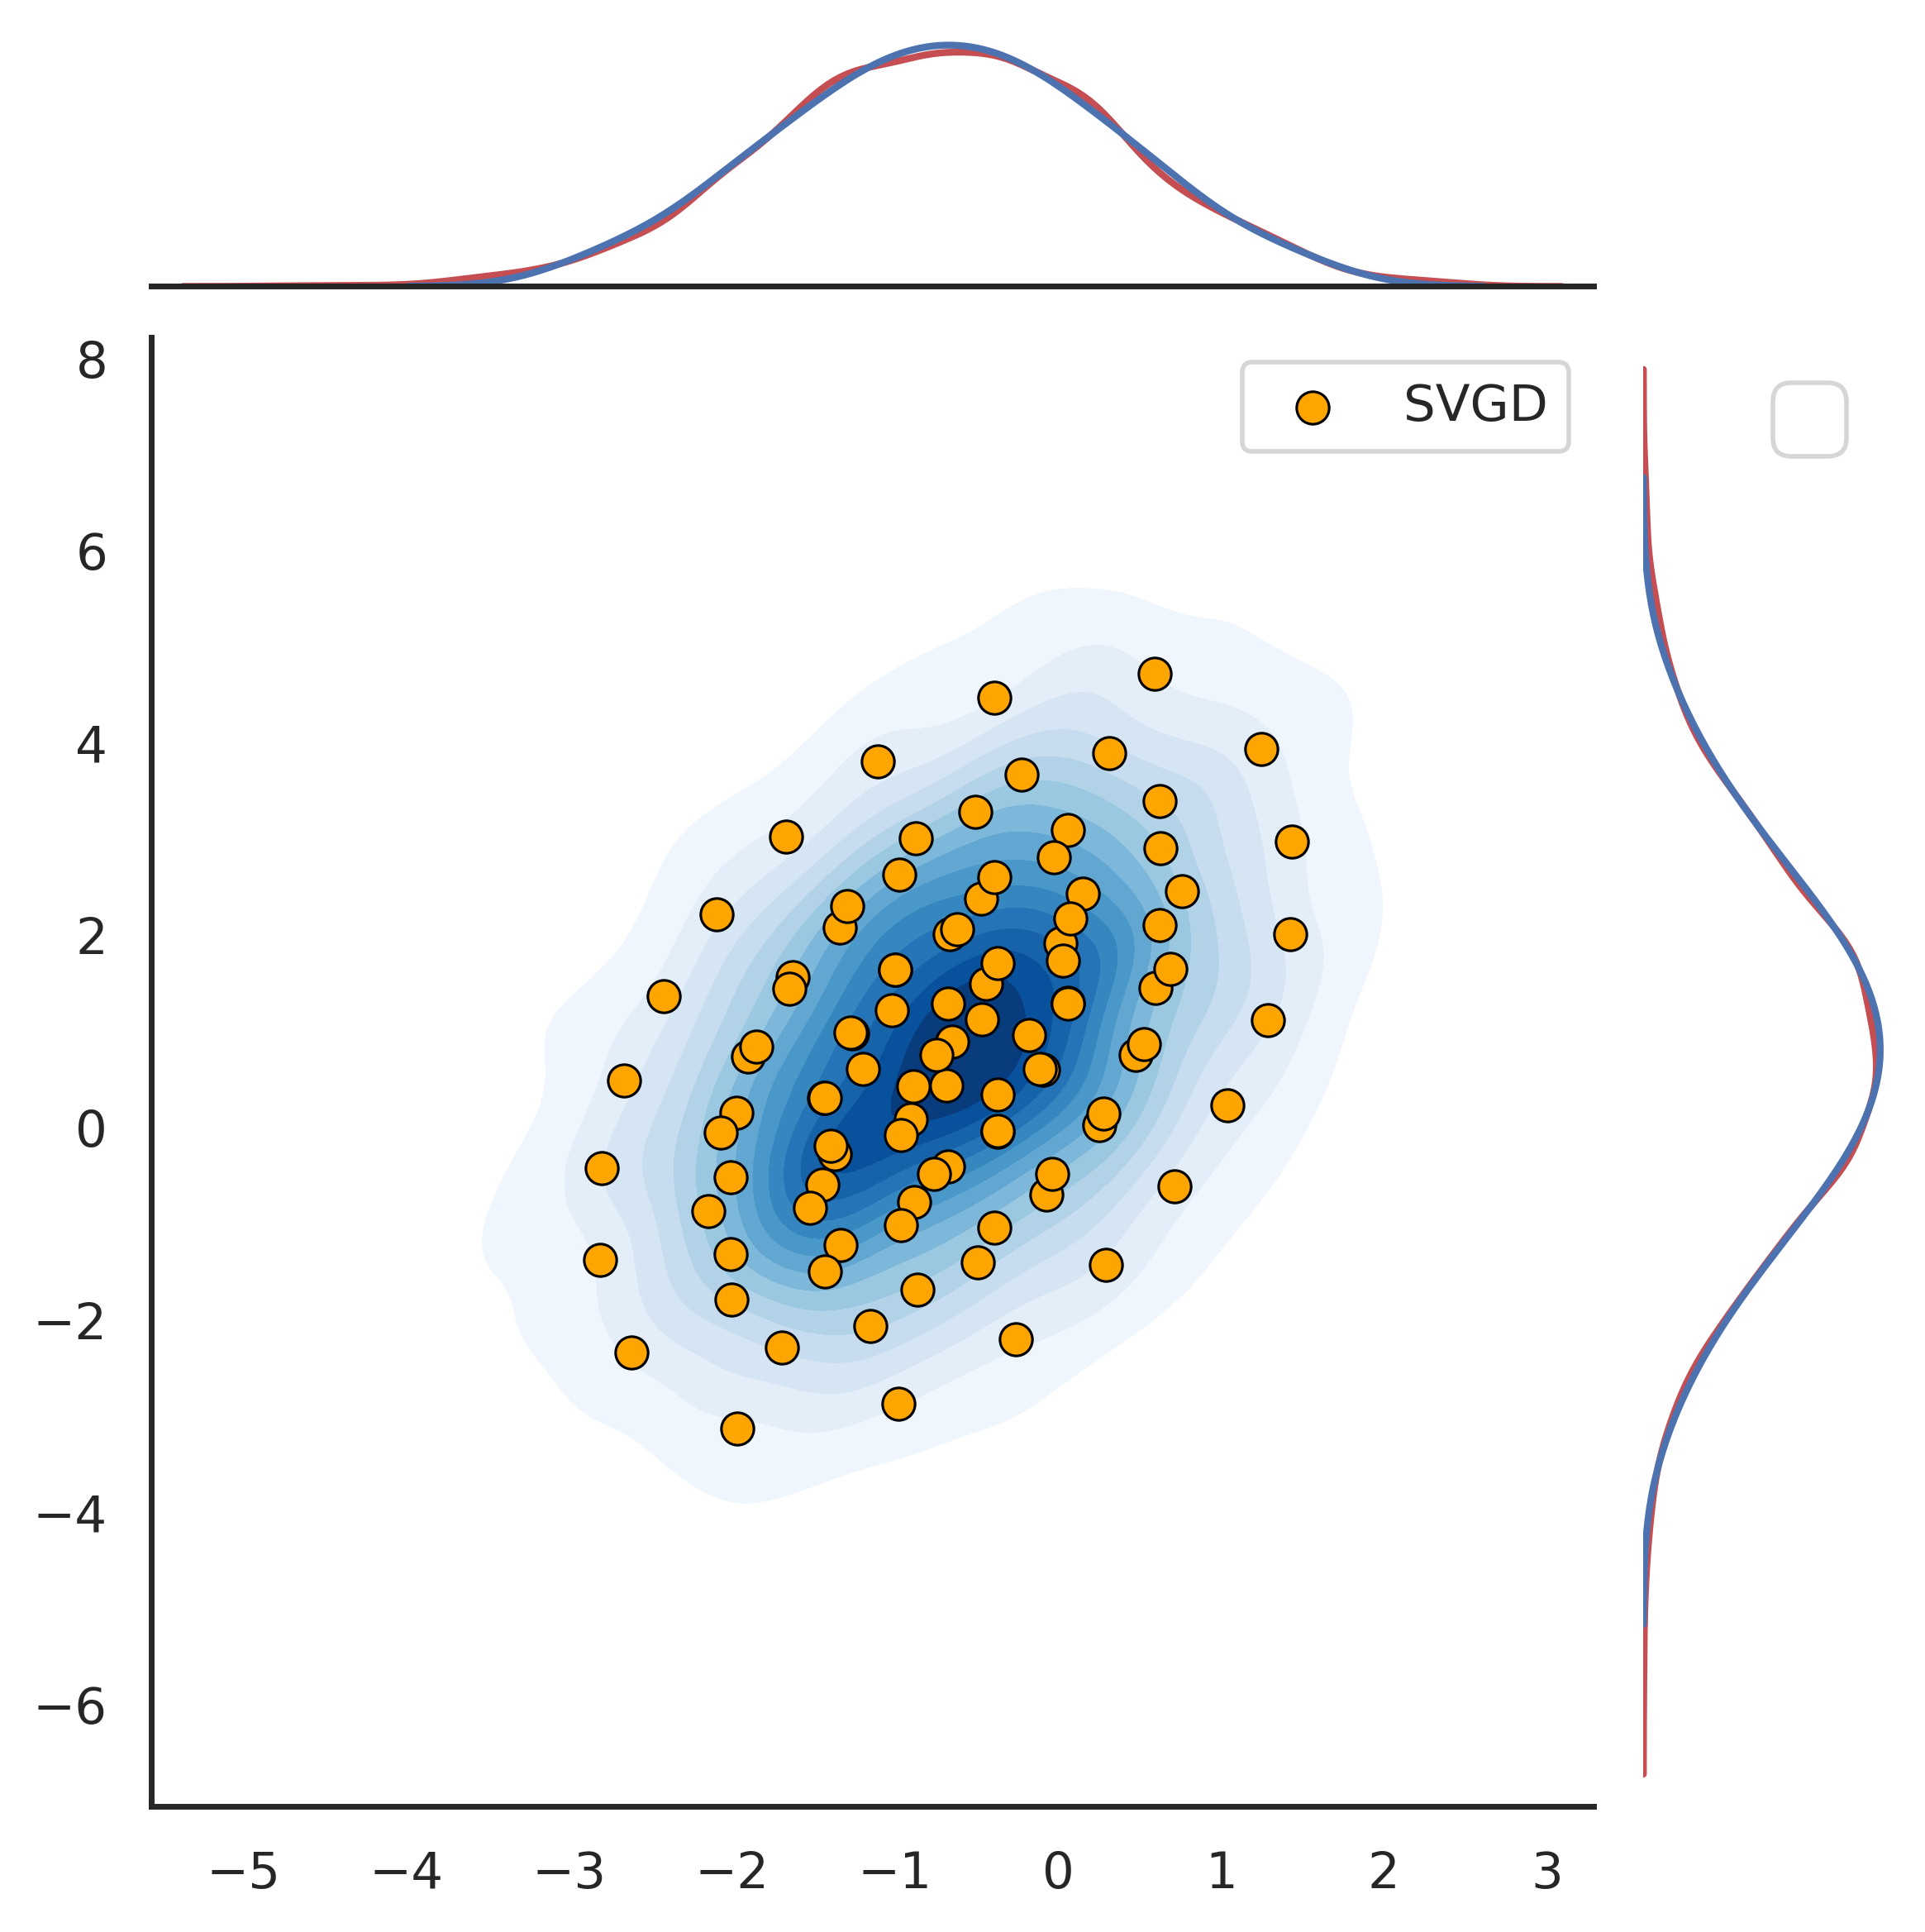

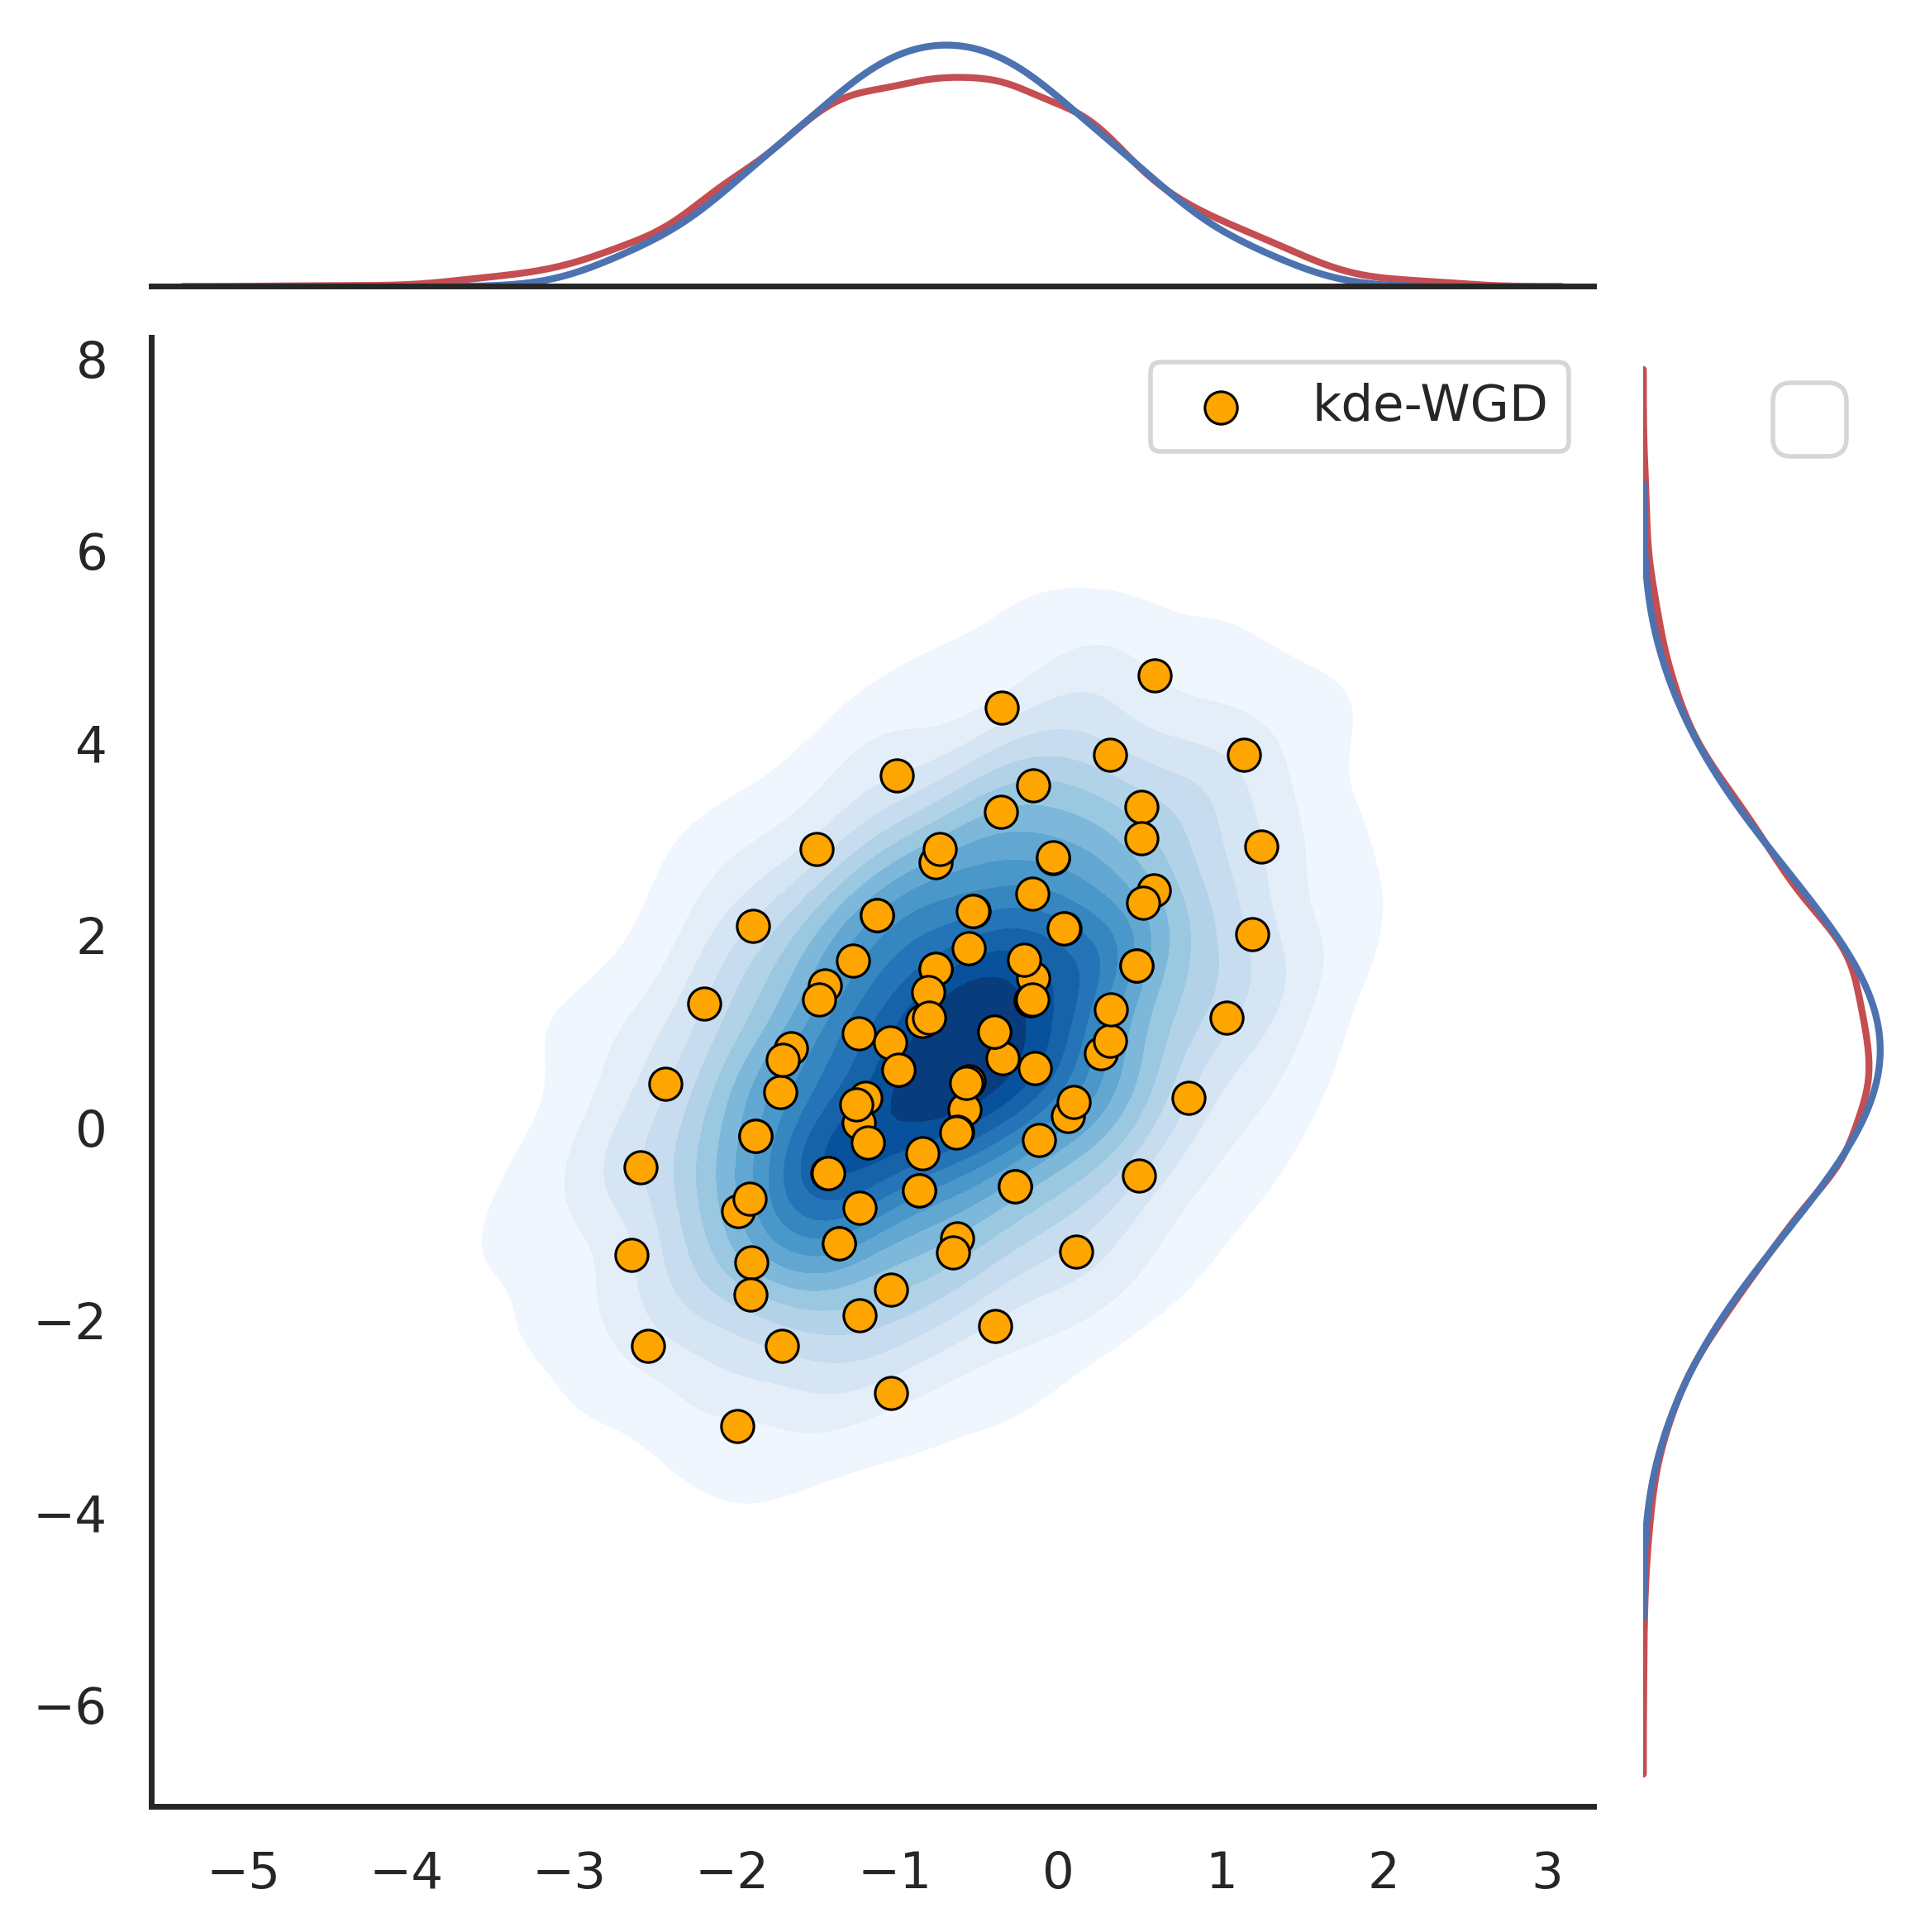

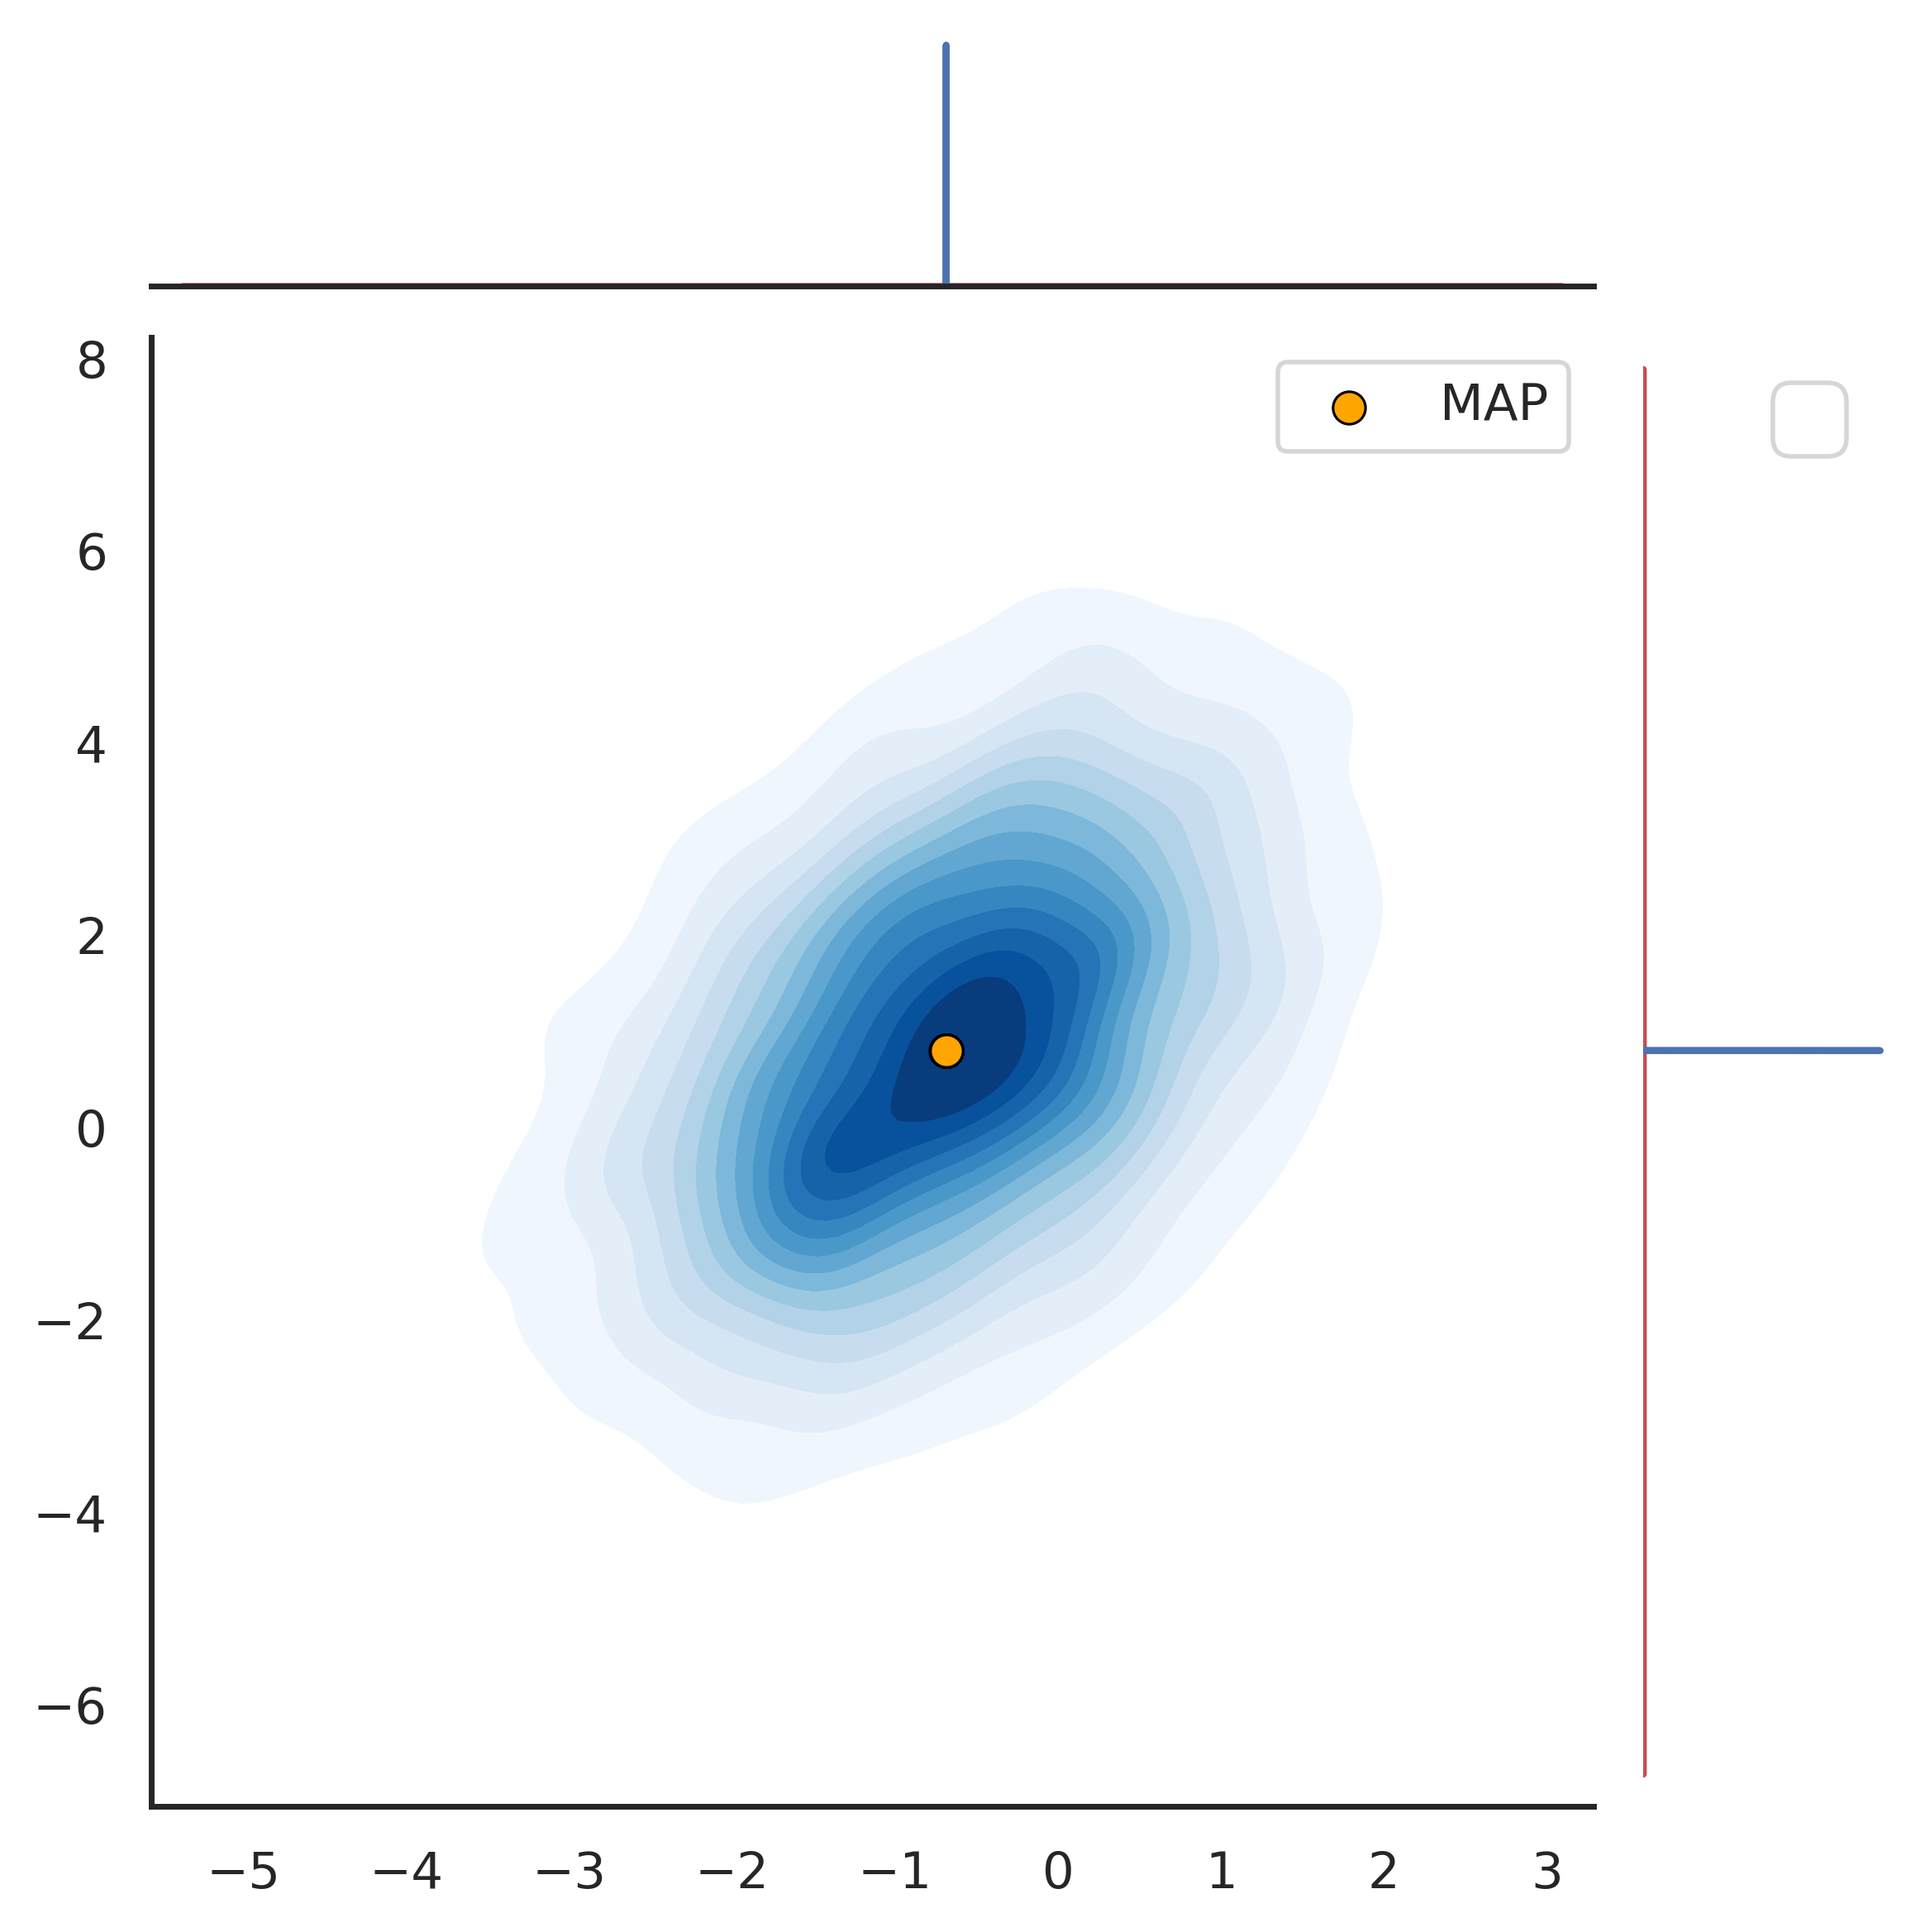

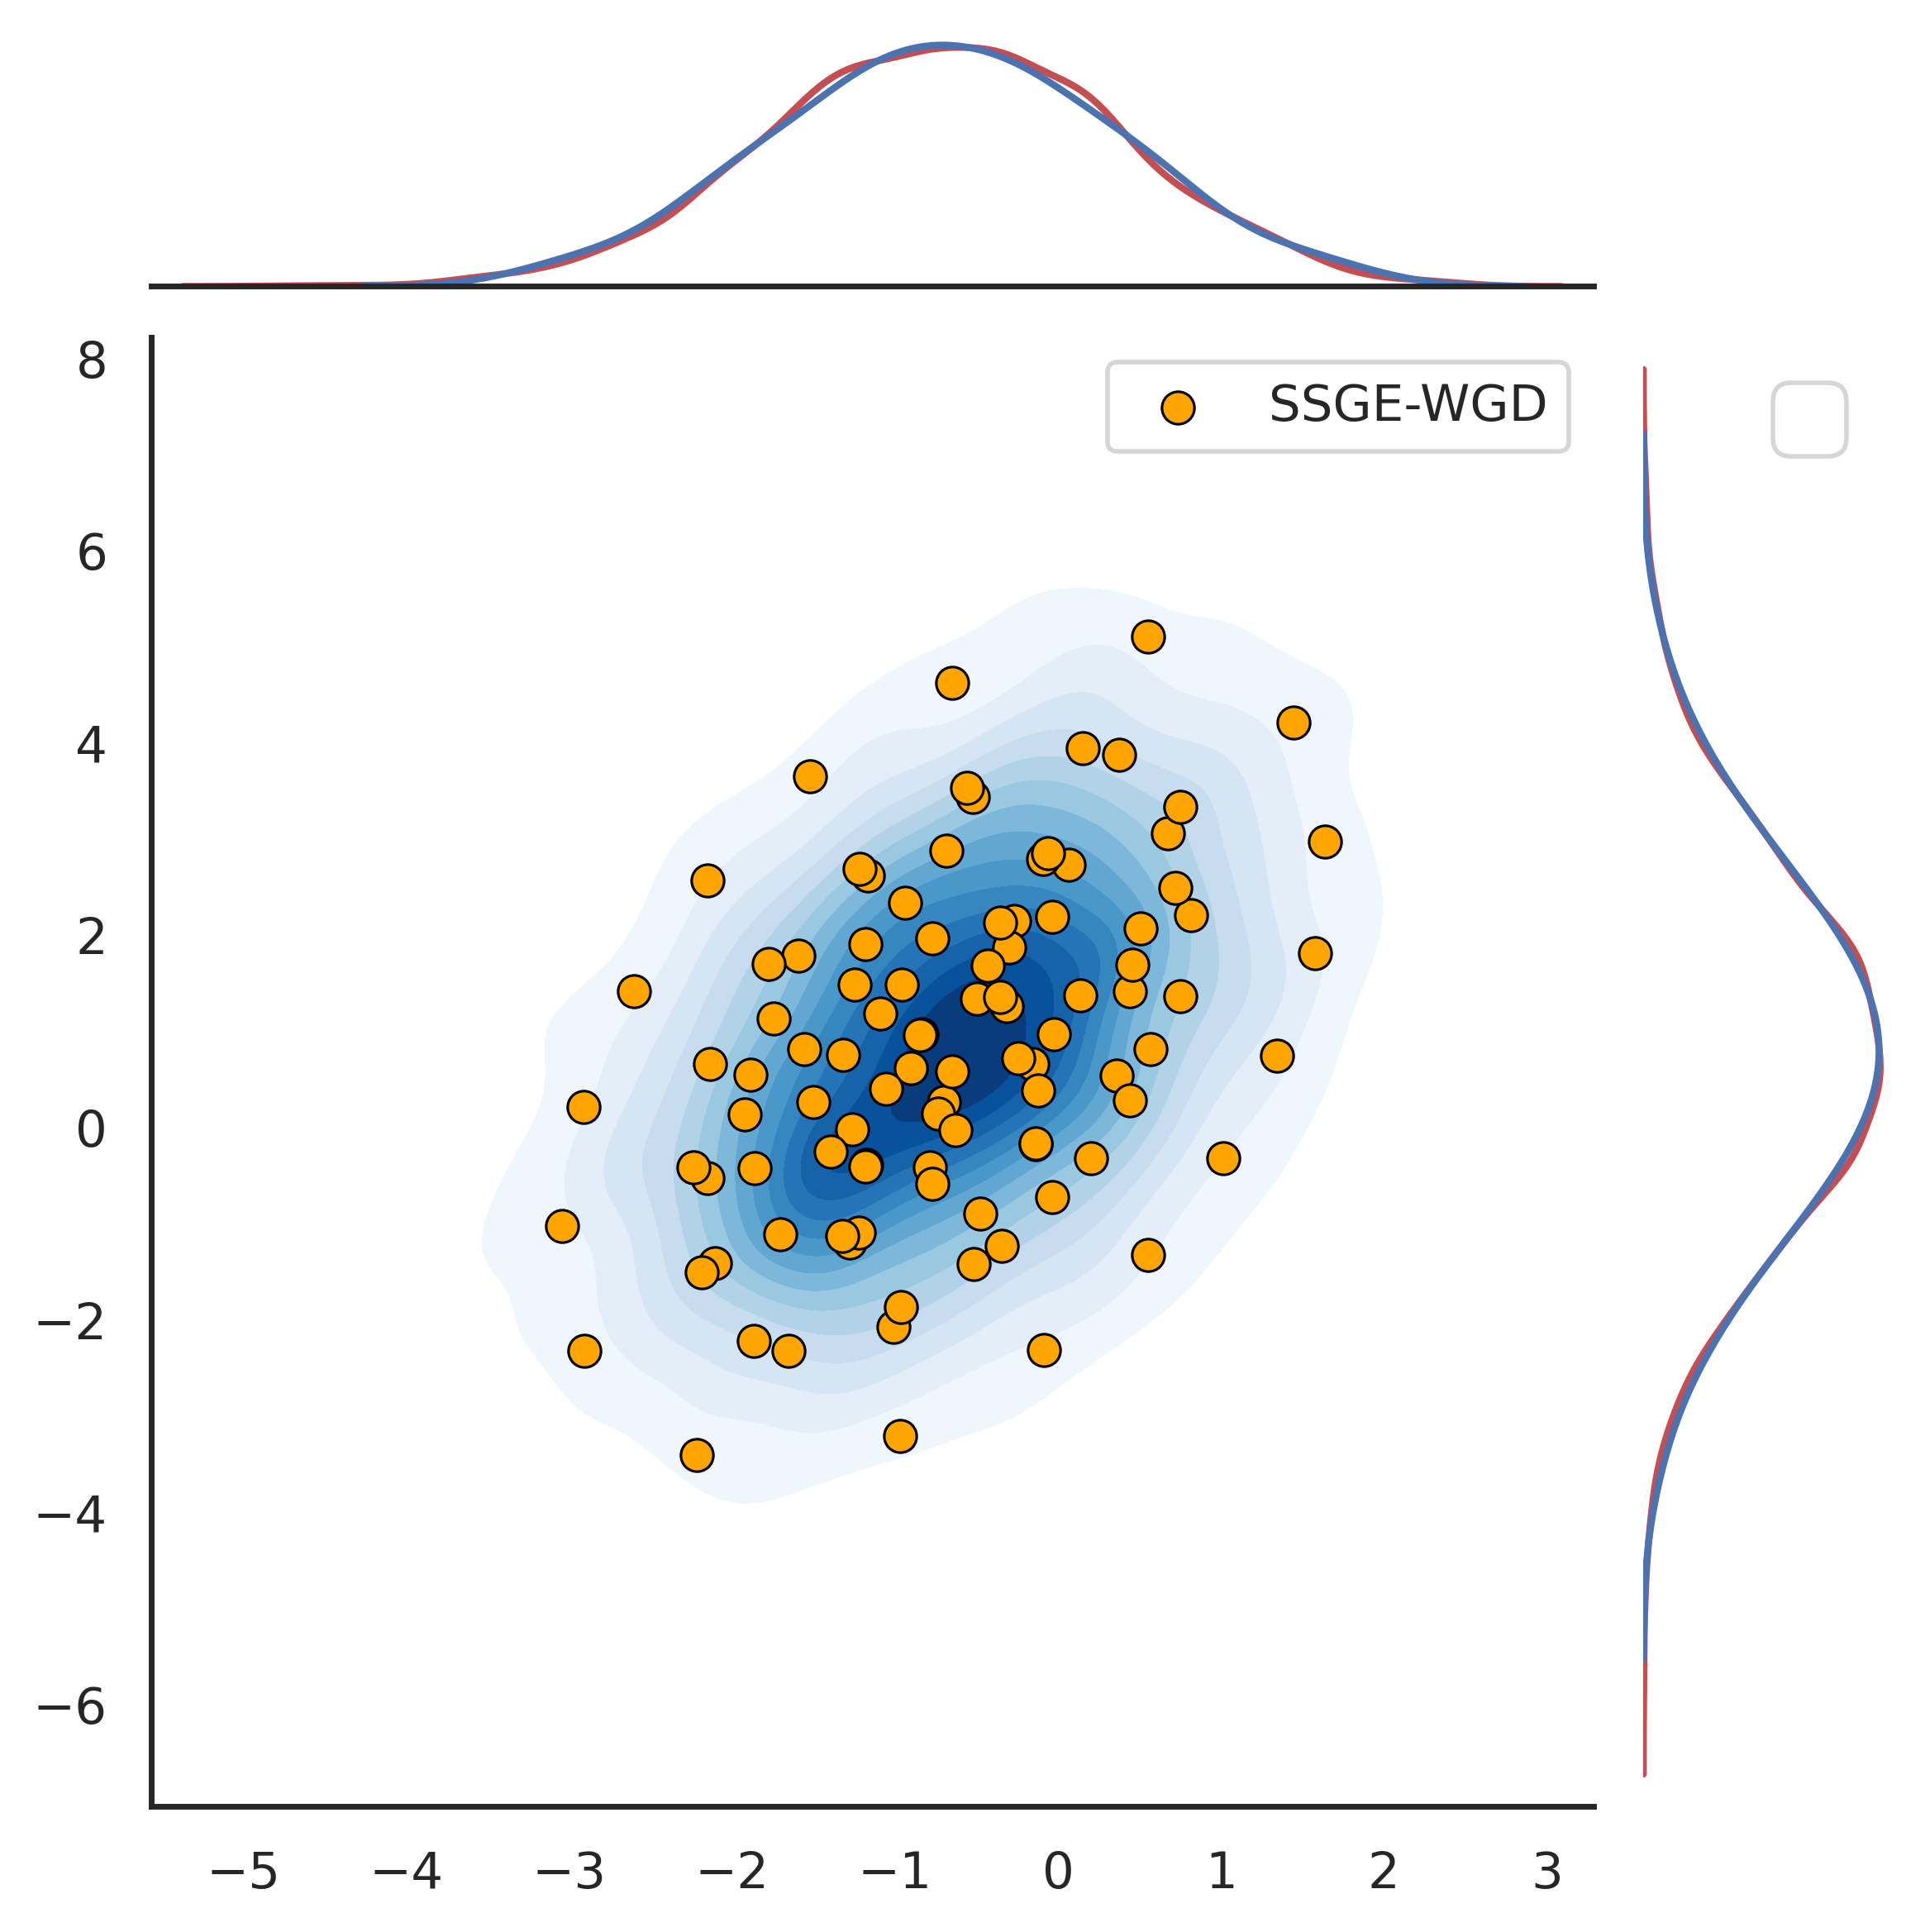

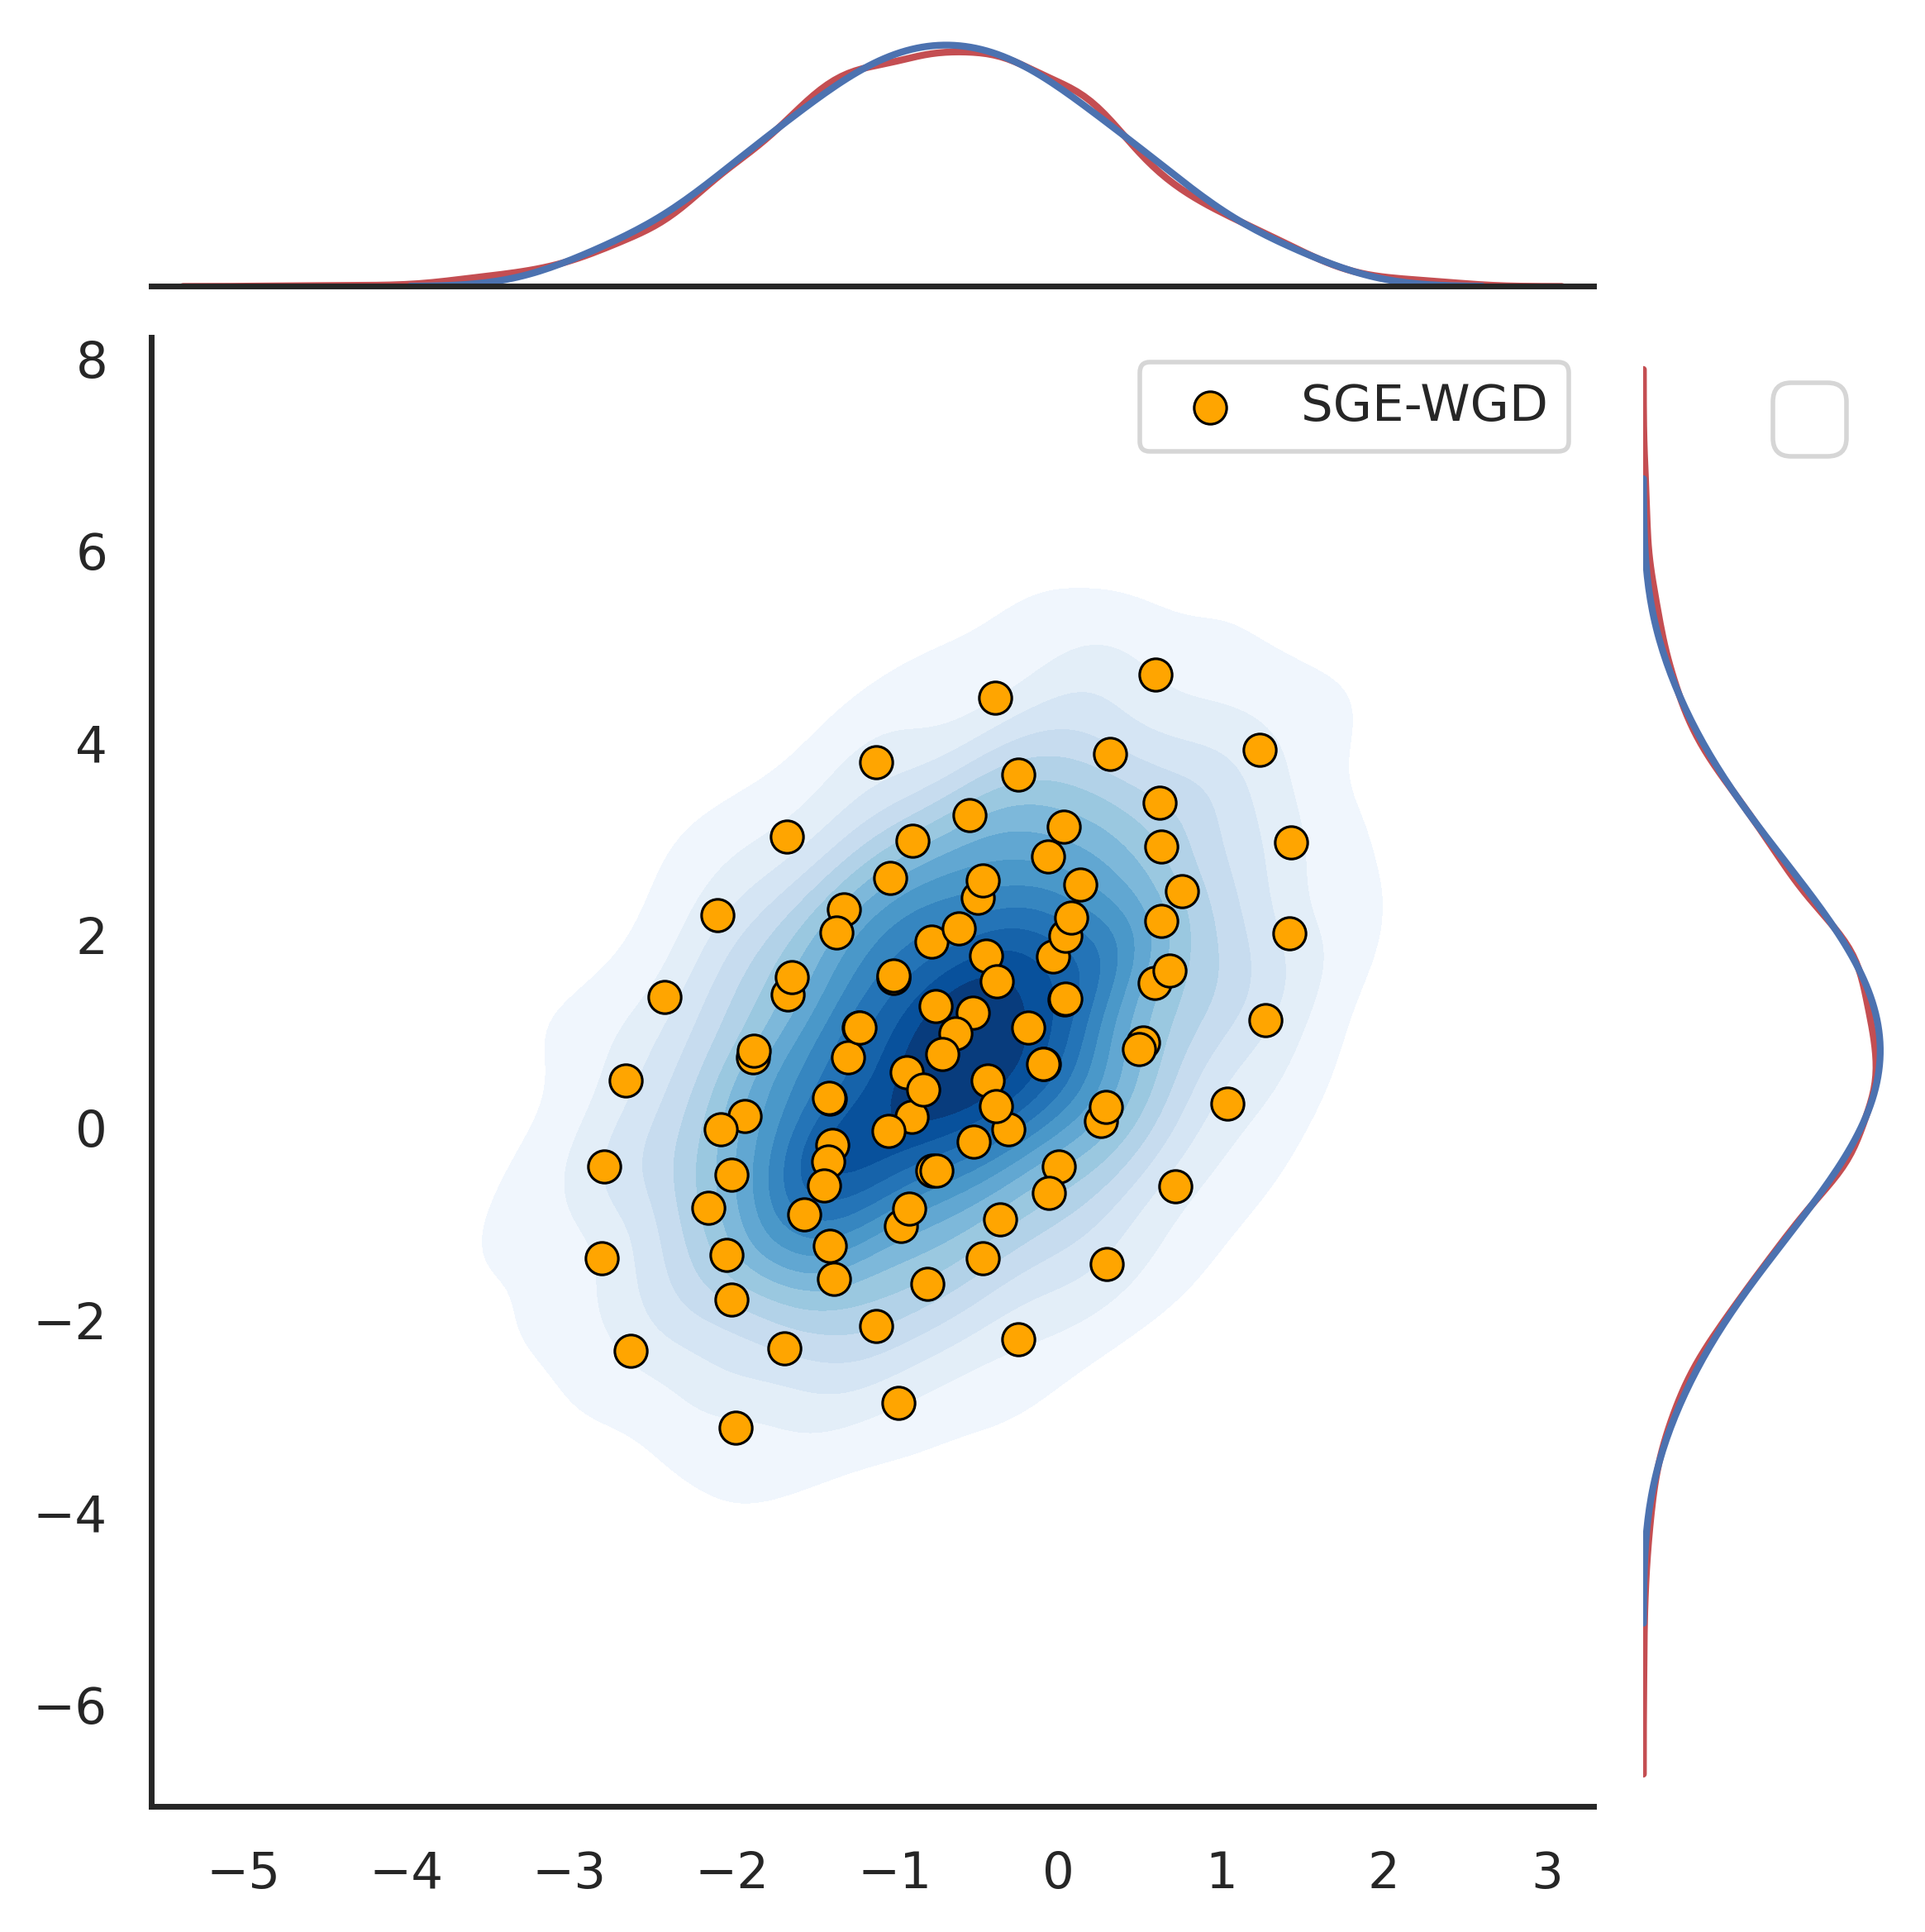

In [17]:
plot_density_particles(samples,X_init,'Init')
plot_density_particles(samples,X_SVGD,'SVGD')
plot_density_particles(samples,X_WGD,'kde-WGD')
plot_density_particles(samples,X_MAP,'MAP')
plot_density_particles(samples,X_ssge_WGD, 'SSGE-WGD')
plot_density_particles(samples,X_sge_WGD,'SGE-WGD')

# Neal's funnel experiments

In [19]:
import torch.distributions as dist
from torch.distributions import constraints
from torch.distributions.utils import _standard_normal
class NealsFunnel(dist.Distribution):
    """
    Neal's funnel.
    p(x,y) = N(y|0,3) N(x|0,exp(y/2))
    """

    support = constraints.real

    def __init__(self, validate_args=None):
        d = 2
        batch_shape, event_shape = torch.Size([]), (d,)
        super(NealsFunnel, self).__init__(
            batch_shape, event_shape, validate_args=validate_args
        )

    def rsample(self, sample_shape=None,device=torch.device("cpu")):
        if not sample_shape:
            sample_shape = torch.Size()
        eps = _standard_normal(
            (sample_shape[0], 2), dtype=torch.float, device=device
        )
        z = torch.zeros(eps.shape)
        z[..., 1] = torch.tensor(3.0) * eps[..., 1]
        z[..., 0] = torch.exp(z[..., 1] / 2.0) * eps[..., 0]
        return z

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        x = value[..., 0]
        y = value[..., 1]

        log_prob = dist.Normal(0, 3).log_prob(y)
        log_prob += dist.Normal(0, torch.exp(y / 2)).log_prob(x)

        return log_prob

# Create Neal's Funnel in 2D
target_dist = NealsFunnel()
#target_dist = torch.distributions.Normal(torch.zeros(input_dim)+5, torch.ones(input_dim)*0.5)
y_target = target_dist.rsample((1000,))

In [39]:
n_pts = 300
range_lim = 4

n = 500

X_init = (5 * torch.randn(n, *torch.Size([2]))).to(device)
test_every = 1
X_SVGD = X_init.clone()
X_WGD = X_init.clone()
X_MAP = X_init.clone()
X_ssge_WGD = X_init.clone()
X_sge_WGD = X_init.clone()


K = RBF()

h = 0.5

p =  NealsFunnel()

svgd = SVGD(p, K, optim.Adam([X_SVGD], lr=1e-1))
wgd = WGD(p, K, optim.Adam([X_WGD], lr=1e-1))
pmap = MAP(p, K, optim.Adam([X_MAP], lr=1e-1))
ssege_wgd = ssge_WGD(p, K, optim.Adam([X_ssge_WGD], lr=1e-1),ssge)
sge_wgd = sge_WGD(p, K, optim.Adam([X_sge_WGD], lr=1e-1))

t_steps = 5000
mmd_ssge_l =[]
mmd_sge_l =[]
mmd_svgd_l =[]
mmd_kde_l =[]
mmd_map_l =[]
for i in tqdm(range(t_steps),position=0, leave=True):       
    svgd.step(X_SVGD)
    wgd.step(X_WGD)
    pmap.step(X_MAP)
    ssege_wgd.step(X_ssge_WGD)
    sge_wgd.step(X_sge_WGD)
    if not i%test_every:
        mmd_ssge =(MMD(y_target,X_ssge_WGD.clone(),h=h,biased = False).item())
        mmd_sge = (MMD(y_target,X_sge_WGD.clone(),h=h,biased = False).item())
        mmd_svgd = (MMD(y_target,X_SVGD.clone(),h=h,biased = False).item())
        mmd_kde = (MMD(y_target,X_WGD.clone(),h=h,biased = False).item())
        mmd_map = (MMD(y_target,X_MAP.clone(),h=h,biased = False).item())

        mmd_ssge_l.append(mmd_ssge)
        mmd_sge_l.append(mmd_sge)
        mmd_svgd_l.append(mmd_svgd)
        mmd_kde_l.append(mmd_kde)
        mmd_map_l.append(mmd_map)

100%|██████████| 5000/5000 [34:56<00:00,  2.38it/s]


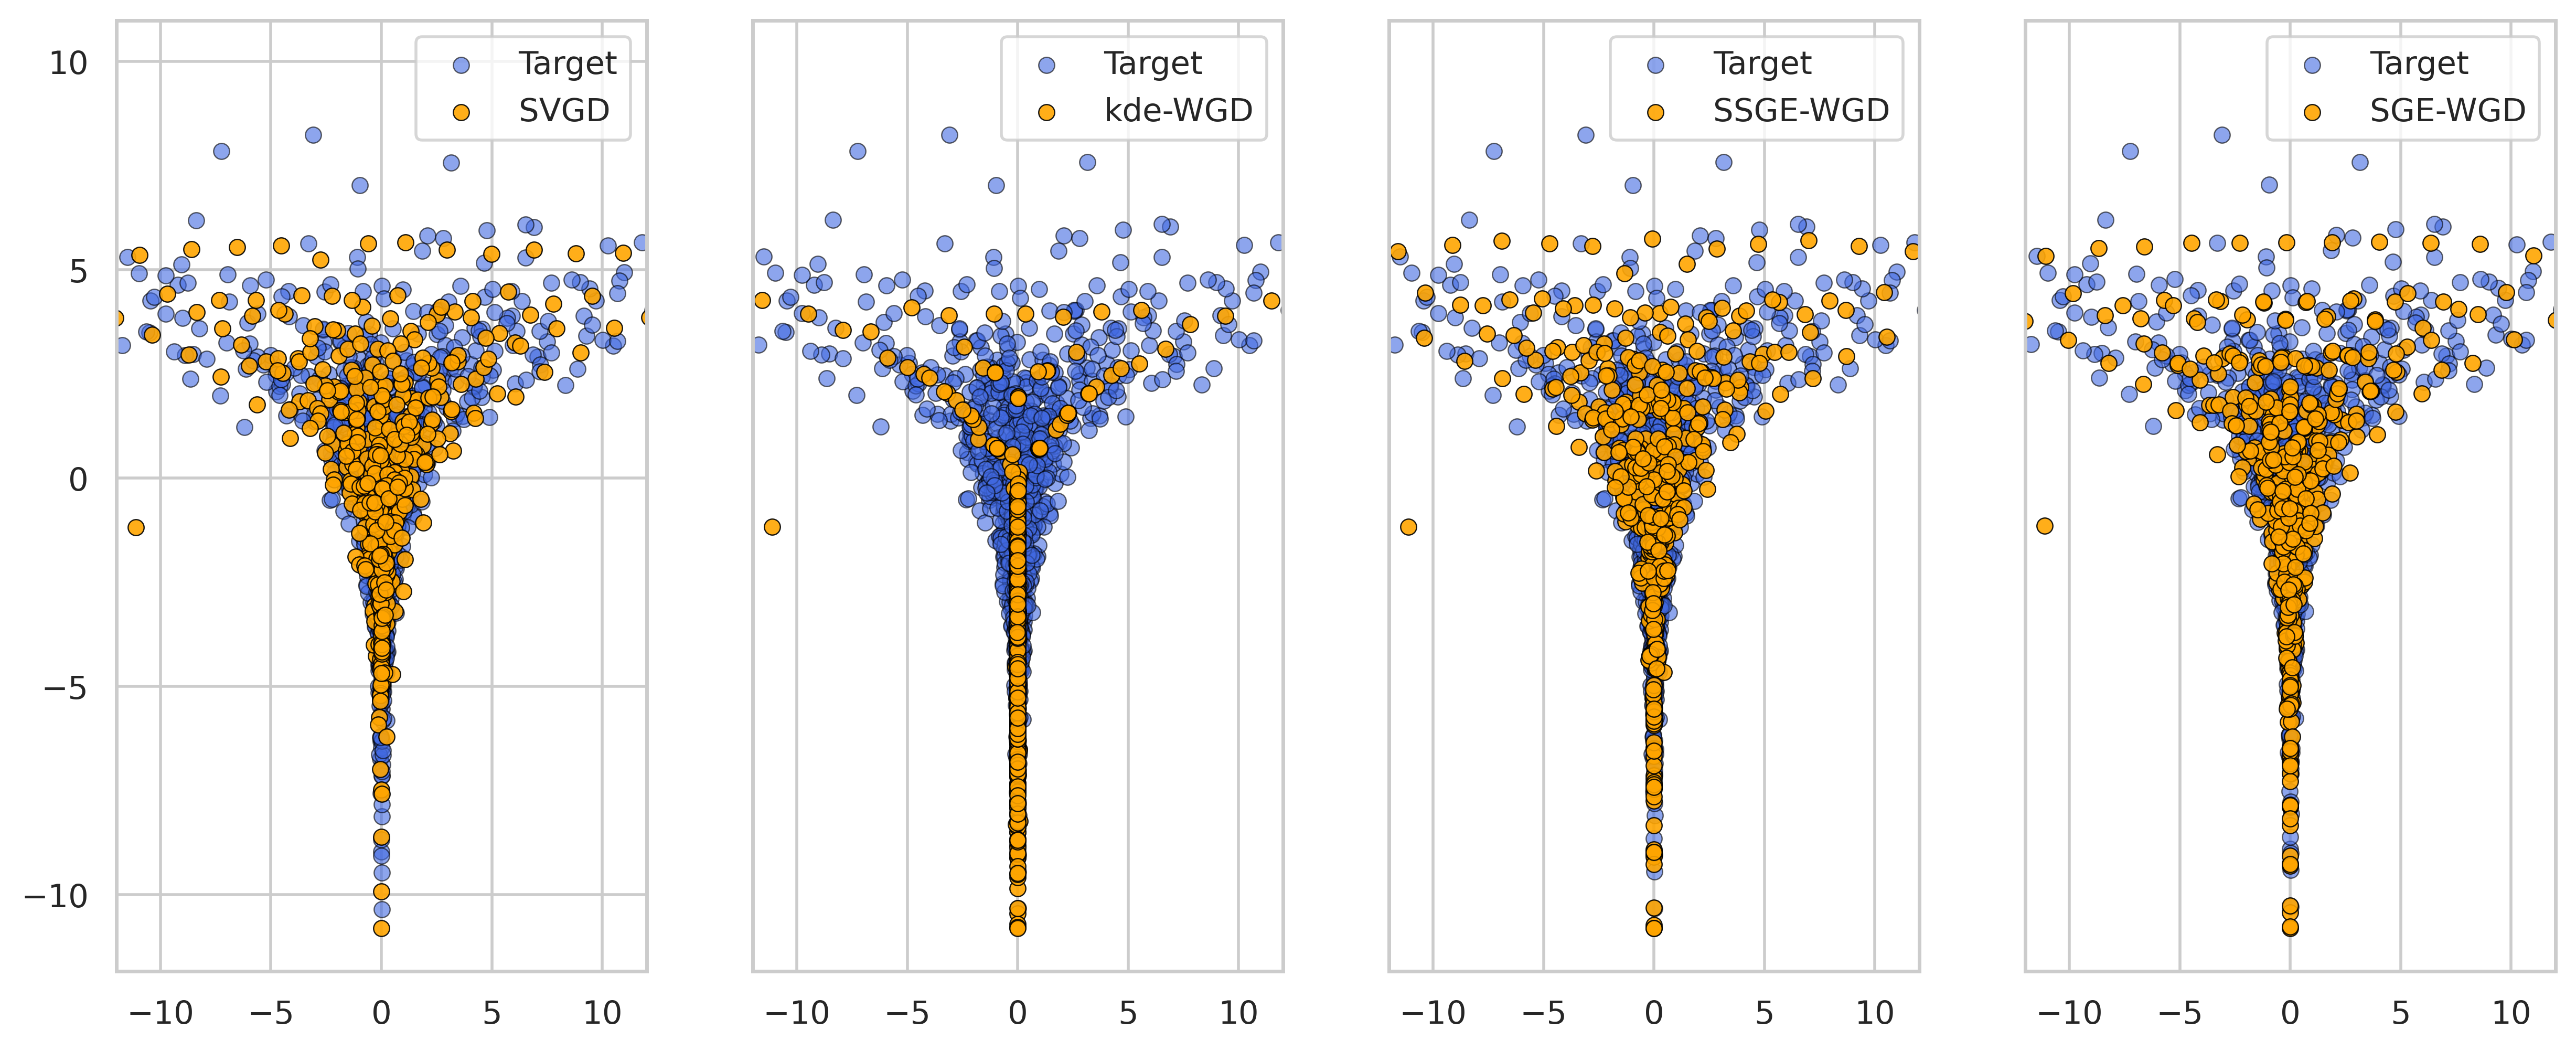

In [41]:
fig, axs = plt.subplots(1, 4, figsize=(15,6))
sns.scatterplot(y_target.detach().numpy()[:,0],y_target.detach().numpy()[:,1], color ='royalblue', alpha = 0.6,s = 30, ax = axs[0], zorder = 1, edgecolor='black', label = 'Target')
sns.scatterplot(X_SVGD.detach().numpy()[:,0],X_SVGD.detach().numpy()[:,1], color ='orange', alpha = 0.9,s = 30, zorder = 1,ax = axs[0], edgecolor='black',label ='SVGD')
#sns.kdeplot(y_target[:,0],y_target[:,1],fill=True, thresh=0, levels=100, cmap="Blues", zorder = 0)

#axs[0].set_title('Funnel SVGD h=median')
axs[0].set_xlim([-12,12])

sns.scatterplot(y_target.detach().numpy()[:,0],y_target.detach().numpy()[:,1], color ='royalblue', alpha = 0.6,s = 30,ax = axs[1], zorder = 1, edgecolor='black', label = 'Target')
sns.scatterplot(X_WGD.detach().numpy()[:,0],X_WGD.detach().numpy()[:,1], color ='orange', alpha = 0.9,s = 30, zorder = 1,ax = axs[1], edgecolor='black', label = 'kde-WGD')
#axs[1].set_title('Funnel WGD h=median')
axs[1].set_xlim([-12,12])
axs[1].set_yticks([])
sns.scatterplot(y_target.detach().numpy()[:,0],y_target.detach().numpy()[:,1], color ='royalblue', alpha = 0.6,s = 30,ax = axs[2], zorder = 1, edgecolor='black', label = 'Target')
sns.scatterplot(X_ssge_WGD.detach().numpy()[:,0],X_ssge_WGD.detach().numpy()[:,1], color ='orange', alpha = 0.9,s = 30, zorder = 1,ax = axs[2], edgecolor='black', label = 'SSGE-WGD')
#axs[2].set_title('Funnel ssge WGD h=median')
axs[2].set_xlim([-12,12])
axs[2].set_yticks([])

sns.scatterplot(y_target.detach().numpy()[:,0],y_target.detach().numpy()[:,1], color ='royalblue', alpha = 0.6,s = 30,ax = axs[3], zorder = 1, edgecolor='black', label = 'Target')
sns.scatterplot(X_sge_WGD.detach().numpy()[:,0],X_sge_WGD.detach().numpy()[:,1], color ='orange', alpha = 0.9,s = 30, zorder = 1,ax = axs[3], edgecolor='black', label = 'SGE-WGD')
#axs[2].set_title('Funnel ssge WGD h=median')
axs[3].set_xlim([-12,12])
axs[3].set_yticks([])

plt.show()